# Recirculated CAV HVAC System

## Introduction
For our group project we have decided to model a recirculated air variable air volume (VAV) HVAC system with heat recovery, heating coils and adiabatic humidification. The schematic diagram for this system is shown below.

<img src="Model Legend.png" style="margin:auto"/>

## Modelled Building
To use our HVAC model we have created an office block in the UK which is shown in the pictures below. To obtain the sensible heat load of the building we will be using the previous code we built for the EVA-DMBEM project in the autumn sesmeter of 2021 which will give an output of the maximum building heat loss coefficient (W/K), $(UA)_{bhlc}$ which can then be used as an input for the HVAC model.

<table>
  <tr>
    <td>Front View Office Block - South Facing</td>
     <td>Back View Office Block - North Facing</td>
  </tr>
  <tr>
    <td><img src="Front View Office Block.jpg" width=270 height=480></td>
    <td><img src="Back View Office Block.jpg" width=270 height=480></td>
  </tr>
 </table>
 
<table>
  <tr>
    <td>Side View Office Block - East/West Facing</td>
  </tr>
  <tr>
    <td><img src="Side View Office Block.jpg" width=270 height=480></td>
  </tr>
 </table>
 
 We have assumed the following for the building:

 * The walls are made of 30 cm thick concrete with a 10cm thick layer of insulation on the inside of the building.
 * The roof is made of 20 cm thick concrete with a 10cm layer of insulation on the interior of the building.
 * The floor is made of 40 cm thick concretr with a 5cm later of insulation on the interior of the building.
 * The windows and door are double glazed.

We have assume that the thermal bridges of the building have been insulated and therefore have a negligible effect on the sensible heat transfer. Therefore, the sensible heat can be calculated using equation 1.2.0 where $\dot{m}_{inf}$, $\theta_{O}$, $\theta_{I}$, $\theta_{0}$, $\dot{Q}_{s,aux}$ can be adjusted in the widget window.

\begin{equation}
\dot{Q}_s = (UA)_{bhlc} (\theta_{O} - \theta_{I}) + \dot{m}_{inf}c(\theta_{0} - \theta_{I}) + \dot{Q}_{s,aux}  \tag{2.0}
\end{equation}

No Temp
No Heat Flow
No Temp
[0. 4. 4. 4. 4. 1. 1. 1. 1. 2. 4.]
[ 0  1  2  3  4  5  6  7  8  9 10]
[[ 1  0  0  0]
 [ 2  4  0  1]
 [ 3  4  0  2]
 [ 4  4  0  3]
 [ 5  4  0  4]
 [ 6  1  0  5]
 [ 7  1  0  6]
 [ 8  1  0  7]
 [ 9  1  0  8]
 [10  2  0  9]
 [11  4  0 10]]
Maximum time step f: 3834.70 s
Maximum time step c: 2321.13 s
Maximum time step h: 406.99 s


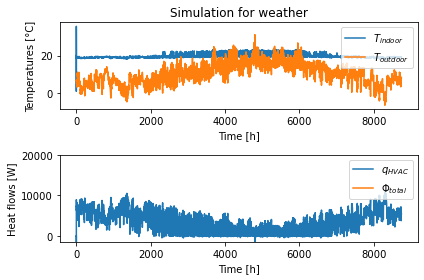

Maximum building heat loss coefficient: 2240.173633871544 W/K
Maximum building heat loss: 10.97609445682285 kW


In [1]:
import main
qHVAC_bhlc_max = main.HLC()

## Adiabatic Mixing
In some cases where mixing occurs the resulting mixing point can have a relative humidity greater than 100 % which is not physically possible as the water in the air will condense as soon as the air is over saturated. This therefore must be compensated for in the computational model by adding adiabatic mixing, where the latent heat of the air at the mixing point is transferred into sensible heat at a constant specific enthalpy value. This will move the mixing point from the oversaturated region to the saturation curve.

The diagram below shows the physical model of the adiabatic mixing which is the theoretical model when the relative humidity is equal to or less than 100%:

<img src="AM physical.JPG" style="margin:auto"/>

The second diagram is the theoretical model with the two adiabatic mixing boxes $ADMX_{1}$ and $ADMX_{2}$ that are included in the code but do not exist in real life.

<img src="AM theoretical.JPG" style="margin:auto"/>

The equation system below is for the theoretical model shown above with the equations sorted by the block they are modelling.

**MX 1**
\begin{equation}
\dot{m}c\theta_1 - (1 - \alpha)\dot{m}c\theta_7 = \alpha\dot{m}c\theta_0 \tag{3.0}
\end{equation}
\begin{equation}
\dot{m}l\omega_1 - (1 - \alpha)\dot{m}l\omega_7 = \alpha\dot{m}l\omega_0 \tag{3.1}
\end{equation}

**MX AD 1**
\begin{equation}
c(\theta_1 - \theta_2) - l(\omega_1 - \omega_2) = 0 \tag{3.2}
\end{equation}
\begin{equation}
f'(\theta_s^0)\theta_2 - \omega_2 = f'(\theta_s^0)\theta_s^0 - \omega_s^0 \tag{3.3}
\end{equation}

**HC 1**
\begin{equation}
\dot{m}c(\theta_2 - \theta_3) + \dot{Q}_{HC1} = 0 \tag{3.4}
\end{equation}
\begin{equation}
\dot{m}l(\omega_2 - \omega_3) = 0 \tag{3.5}
\end{equation}

**AH**
\begin{equation}
c(\theta_3 - \theta_4) + l(\omega_3 - \omega_4) = 0 \tag{3.6}
\end{equation}
\begin{equation}
f'(\theta_s^0)\theta_4 - \omega_4 = f'(\theta_s^0)\theta_s^0 - \omega_s^0 \tag{3.7}
\end{equation}

**MX 2**
\begin{equation}
\beta\dot{m}c\theta_3 + (1 - \beta)\dot{m}c\theta_3 - \dot{m}c\theta_5 = 0 \tag{3.8}
\end{equation}
\begin{equation}
\beta\dot{m}l\omega_3 + (1 - \beta)\dot{m}l\omega_3 - \dot{m}l\omega_5 = 0 \tag{3.9}
\end{equation}

**MX AD 2**
\begin{equation}
c(\theta_5 - \theta_6) - l(\omega_5 - \omega_6) = 0 \tag{3.10}
\end{equation}
\begin{equation}
f'(\theta_s^0)\theta_6 - \omega_6 = f'(\theta_s^0)\theta_s^0 - \omega_s^0 \tag{3.11}
\end{equation}

**HC 2**
\begin{equation}
\dot{m}c(\theta_6 - \theta_7) + \dot{Q}_{HC2} = 0 \tag{3.12}
\end{equation}
\begin{equation}
\dot{m}l(\omega_6 - \omega_7) = 0 \tag{3.13}
\end{equation}

**TZ**
\begin{equation}
\dot{m}c(\theta_6 - \theta_7) + \dot{Q}_{s} = 0 \tag{3.14}
\end{equation}
\begin{equation}
\dot{m}l(\omega_6 - \omega_7) + \dot{Q}_{l} = 0 \tag{3.15}
\end{equation}

**BL**
\begin{equation}
(UA_{bhlc} + \dot{m}_{inf}c)\theta_8 + \dot{Q}_{s} = (UA_{bhlc} + \dot{m}_{inf}c)\theta_0 + \dot{Q}_{s,aux} \tag{3.16}
\end{equation}
\begin{equation}
\dot{m}_{inf}l\omega_8 + \dot{Q}_{l} = \dot{m}_{inf}l\omega_0 + \dot{Q}_{l,aux} \tag{3.17}
\end{equation}

**$K_{\theta}$ and $K_{\omega}$**
\begin{equation}
K_{\theta}\theta_8 + \dot{Q}_{HC1} = K_{\theta}\theta_{isp} \tag{3.18}
\end{equation}
\begin{equation}
K_{\omega}\omega_8 + \dot{Q}_{HC2} = K_{\omega}\omega_{isp} \tag{3.19}
\end{equation}
These equations can be written in the matrix form **A** **x** = **b**

$ \color{black}{ A= \left(\begin{array}{cc}
\dot{m}c & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -(1 - \alpha)\dot{m}c & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
0 & \dot{m}l & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -(1 - \alpha)\dot{m}l & 0 & 0 & 0 & 0 & 0 & 0 \\  
c & l & -c & -l & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & f'(\theta_s^0) & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & \dot{m}c & 0 & -\dot{m}c & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & \dot{m}l & 0 & -\dot{m}l & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & c & l & -c & -l & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & f'(\theta_s^0) & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & \beta\dot{m}c & 0 & (1 - \beta)\dot{m}c & 0 & -\dot{m}c & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & \beta\dot{m}l & 0 & (1 - \beta)\dot{m}l & 0 & -\dot{m}l & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & c & l & -c & -l & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & f'(\theta_s^0) & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \dot{m}c & 0 & -\dot{m}c & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \dot{m}l & 0 & -\dot{m}l & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \dot{m}c & 0 & -\dot{m}c & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \dot{m}l & 0 & -\dot{m}l & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & (UA+\dot{m}_{inf}c) & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \dot{m}_{inf}c & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & K_{\theta} & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & K_{\omega} & 0 & 1 & 0 & 0 \\
\end{array}\right)
}$

$ \color{black}{ x= \left(\begin{array}{cc}
\theta_1 \\ 
\omega_1 \\ 
\theta_2 \\ 
\omega_2 \\
\theta_3 \\ 
\omega_3 \\
\theta_4 \\ 
\omega_4 \\
\theta_5 \\ 
\omega_5 \\
\theta_6 \\ 
\omega_6 \\
\theta_7 \\ 
\omega_7 \\
\theta_8 \\ 
\omega_8 \\
\dot{Q}_{HC1} \\
\dot{Q}_{HC2} \\
\dot{Q}_s \\
\dot{Q}_l \\
\end{array}\right)
}$
    
$ \color{black}{ b= \left(\begin{array}{cc}
\alpha\dot{m}c\theta_0 \\ 
\alpha\dot{m}l\omega_0 \\ 
0 \\ 
f'(\theta_s^0)\theta_s^0 - \omega_s^0 \\
0 \\
0 \\
0 \\
f'(\theta_s^0)\theta_s^0 - \omega_s^0 \\
0 \\
0 \\
0 \\
f'(\theta_s^0)\theta_s^0 - \omega_s^0 \\
0 \\
0 \\
0 \\
0 \\
(UA+\dot{m}_{inf}c)\theta_0+\dot{Q}_{s,aux} \\
\dot{m}_{inf}l\omega_0+\dot{Q}_{l,aux} \\
K_{\theta}\theta_{isp} \\
K_{\omega}\omega_{isp} \\
\end{array}\right)
}$

The basis code of the above model are the functions ModelRecAir and RecAirVAV from the file ad_hum.py. Since the model contains two mixing boxes, there are four possible cases each one with a different A-matrix:

    1. The mixingpoints after both the first and the second mixing boxes are below a relative humidity (RH) of 100 %
        --> no adiabatic mixing has to be added.
    2. The mixingpoint after the first mixing box is below 100 % RH but the mixingpoint after the second is above 100 % RH
        --> adiabatic mixing has to be added to the second.
    3. The mixingpoint after the first mixing box is above 100 % RH and the mixingpoint after the second is below 100 % RH
        --> adiabatic mixing has to be added to the first.
    4. The mixingpoints after both the first and the second mixing box are above 100 % RH.
        --> adiabatic mixing has to be added to both.
    
 For each case new "ModelRecAir" and "RecAirVAV" functions were created:
     
    1.  ModelRecAirmxmx, RecAirVAVmxmx
    2.  ModelRecAirmxma, RecAirVAVmxma
    3.  ModelRecAirmamx, RecAirVAVmamx
    4.  ModelRecAirmama, RecAirVAVmama
    
To decide which of these submodels has to be used, the algorithm introduced in the file mix.py was used. This means, that first a solution vector x is calculated with the RecAirVAV_adTest function, which is equivalent to the RecAirVaVmama function, but does not producce a diagram and returns x. After that it is checked whether the mixingpoints are below the saturation curve by comparing the humidity ratio of the point to the humidity ratio at a 100 % RH at the same temperature. According to this the correct model is called.

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import psychro as psy

# %matplotlib inline  # uncomment for inline figure
# uncomment for figure in separate window
# %matplotlib qt
# plt.show()

plt.rcParams["figure.figsize"] = (30,20)
font = {'weight' : 'bold',
        'size'   : 30}
plt.rc('font', **font)

def RecAirVAV_wd(α=1, β=0.1, θS=30, θIsp=18, φIsp=0.5, θO=-1, φO=1):
    Qsa = 0.
    Qla = 0.
    mi = 2.12
    UA = qHVAC_bhlc_max
    from ad_hum import RecAirVAVmxmx, RecAirVAVmxma, RecAirVAVmamx, RecAirVAVmama, RecAirVAV_adTest
    
    x = RecAirVAV_adTest(α, β, θS, θIsp, φIsp, θO, φO, Qsa, Qla, mi, UA)

    if x[9] > psy.w(x[8], 1):
        if x[1] > psy.w(x[0], 1):
            RecAirVAVmama(α, β, θS, θIsp, φIsp, θO, φO, Qsa, Qla, mi, UA)
            print('mama')
        else:
            RecAirVAVmxma(α, β, θS, θIsp, φIsp, θO, φO, Qsa, Qla, mi, UA)
            print('mxma')
    elif x[1] > psy.w(x[0], 1):
        RecAirVAVmamx(α, β, θS, θIsp, φIsp, θO, φO, Qsa, Qla, mi, UA)
        print('mamx')
    else:
        RecAirVAVmxmx(α, β, θS, θIsp, φIsp, θO, φO, Qsa, Qla, mi, UA)
        print('mxmx')
    
interact(RecAirVAV_wd, α=(0, 1, 0.1), β=(0, 0.99, 0.1), θSsp=(20, 50, 2),
         θIsp=(17, 25, 1), φIsp=(0, 1, 0.1),
         θO = (-10., 17., 2), φO = (0, 1, 0.1));

interactive(children=(FloatSlider(value=1.0, description='α', max=1.0), FloatSlider(value=0.1, description='β'…

## Heat Recovery
We have created a model for the heat recovery component of the system which extracts the heat from the exhaust air and transfers it to the incoming air using a heat exchanger. The three process blocks in the model is the cooling side of the exchanger (***XC***), the heating side of the exchanger (***XH***) and the mixing of the cooled and non-cooled exhaust air (***XM***). ***s*** denotes that the exit flow from XC is saturated vapour, where condensing of the water vapour has occured. The model is shown in the diagram below.

<img src="Heat Exchanger Model.png" style="margin:auto"/>

There are 9 unknown variables in the system:
<p style="text-align: center;">$\theta_s$, $\omega_s$, $\theta_2$, $\theta_4$, $\omega_4$, $\dot{Q}_s$, $\dot{Q}_l$, $\dot{Q}_x$, $\dot{m}_w$ </p>

There are 9 known variables in the system:
<p style="text-align: center;">$\theta_1$, $\omega_1$, $\theta_3$, $\omega_3$, $\gamma$, $\dot{m}_{da}$, $\theta_s^0$, $\omega_s^0$, $f'(\theta_s^0)$</p>

The 3 material characteristics of the the system are:
<p style="text-align: center;">$(UA)_{hx}$, $c_{da}$, $l$

We therefore need 9 linear equations to solve for the number of unknown variables. These are shown below with the unknown values on the left hand side and the known variables on the righthand side:
\begin{equation}
\dot{Q}_x - \dot{Q}_s - \dot{Q}_l = 0  \tag{1.2.0}
\end{equation}
\begin{equation}
(UA)_{hx}\theta_2 - (UA)_{hx}\theta_4 + 2\dot{Q}_s + 2\dot{Q}_l = (UA)_{hx}(\theta_3 - \theta_3) \tag{1.2.1}
\end{equation}
\begin{equation}
\dot{m}_{da}c_{da}\theta_2 - \dot{Q}_x - h_e\dot{m}_{w} = \dot{m}_{da}c_{da}\theta_1 \tag{1.2.2}
\end{equation}
\begin{equation}
\dot{m}_{w} = \dot{m}_{da}(\omega_3 - \omega_4) \tag{1.2.3}
\end{equation}
\begin{equation}
(1 - \gamma)\dot{m}_{da}c_{da}\theta_s + \dot{Q}_s = (1 - \gamma)\dot{m}_{da}c_{da}\theta_3 \tag{1.2.4}
\end{equation}
\begin{equation}
(1 - \gamma)\dot{m}_{da}l\omega_s + \dot{Q}_l = (1 - \gamma)\dot{m}_{da}l\omega_3 \tag{1.2.5}
\end{equation}
\begin{equation}
f'(\theta_s^0)\theta_s - \omega_s = f'(\theta_s^0)\theta_s^0 - \omega_s^0 \tag{1.2.6}
\end{equation}
\begin{equation}
\theta_4 - (1 - \gamma)\theta_s = \gamma\theta_3 \tag{1.2.7}
\end{equation}
\begin{equation}
\omega_4 - (1 - \gamma)\omega_s = \gamma\omega_3 \tag{1.2.8}
\end{equation}
    
The term $h_{e}\dot{m}_{w}$ in equation (1.2.2) can be neglected as $\dot{m}_{w}<<\dot{m}_{da}$. This means we can also neglect equation (1.2.3) as it will have no significant effect on the system. By excluding $\dot{m}_{w}$ this means there are now only 8 unknown variables and therefore only 8 linear equations are required. $(UA)_{hx}$ is the heat transfer coefficient of the heat exchanger and **not** the heat transfer coefficient of the building.

The linear system of equations can be expressed in the matrix form **A** ***x*** = **b** where **A** is an 8 x 8 matrix containing the coefficients of the unknown variables, ***x*** is a 8 x 1 tensor of the unknown variables and **b** is a  8 x 1 tensor of the known values. These are shown below for defined system of linear equations.
    
$ \color{black}{ A= \left(\begin{array}{cc}
0 & 0 & 0 & 0 & 0 & -1 & -1 & 1 \\ 
(UA)_{hx} & 0 & 0 & -(UA)_{hx} & 0 & 2 & 2 & 0 \\ 
\dot{m}_{da}c_{da} & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\ 
0 & (1 - \gamma)\dot{m}_{da}c_{da} & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & (1 - \gamma)\dot{m}_{da}l & 0 & 0 & 1 & 0 & 0 \\
0 & f'(\theta_s^0) & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & -(1 - \gamma) & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & -(1 - \gamma) & 0 & 1 & 0 & 0 & 0
\end{array}\right)
}$

$ \color{black}{ x= \left(\begin{array}{cc}
\theta_2 \\ 
\theta_s \\ 
\omega_s \\ 
\theta_4 \\ 
\omega_4 \\
\dot{Q}_l \\
\dot{Q}_s \\
\dot{Q}_x \\
\end{array}\right)
}$
    
$ \color{black}{ b= \left(\begin{array}{cc}
0 \\ 
(UA)_{hx}(\theta_3 - \theta_4) \\ 
\dot{m}_{da}c_{da}\theta_1 \\ 
(1 - \gamma)\dot{m}_{da}c_{da}\theta_3 \\
(1 - \gamma)\dot{m}_{da}l\omega_3 \\
f'(\theta_s^0)\theta_s^0 - \omega_s^0 \\
\gamma\theta_3 \\
\gamma\omega_3 \\
\end{array}\right)
}$

The code for solving this linear set of equations is shown below which creates a pyschrometric chart with sliders of the input variables to see how the behaviour of the system changes.

## CAV HVAC Heating and Humidification System